[*********************100%***********************]  5 of 5 completed
C:\Users\aadis\AppData\Local\Temp\ipykernel_22688\179633410.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").dropna(axis=0, how="any")  # align


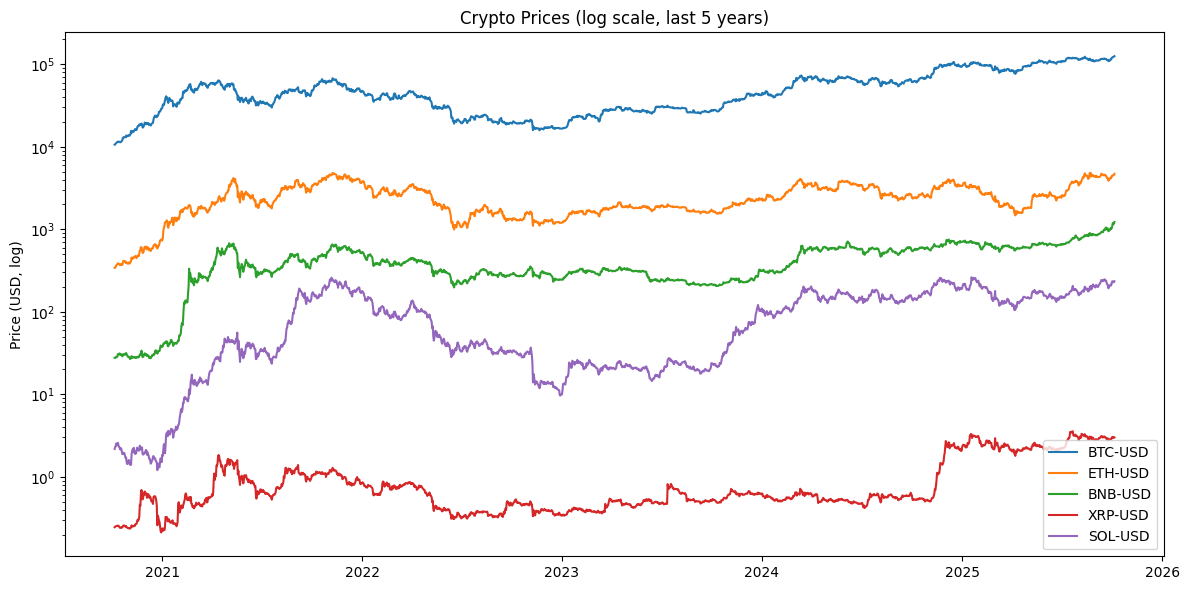

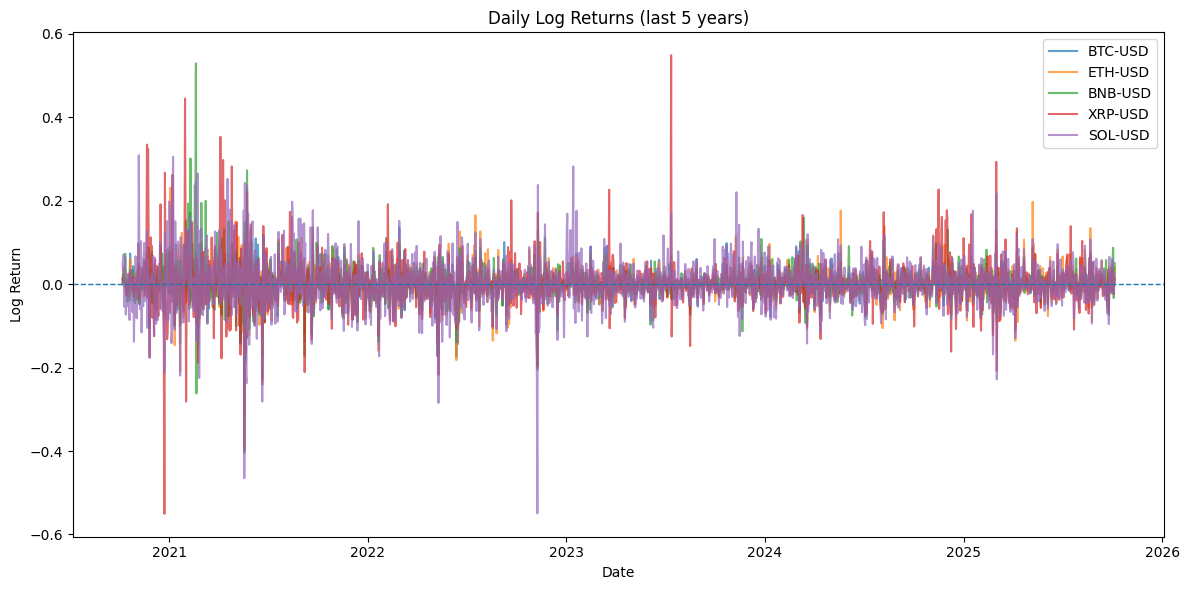


=== Pearson Correlation of Daily Returns (5Y) ===
Ticker   BNB-USD  BTC-USD  ETH-USD  SOL-USD  XRP-USD
Ticker                                              
BNB-USD    1.000    0.653    0.672    0.576    0.510
BTC-USD    0.653    1.000    0.806    0.583    0.558
ETH-USD    0.672    0.806    1.000    0.650    0.588
SOL-USD    0.576    0.583    0.650    1.000    0.500
XRP-USD    0.510    0.558    0.588    0.500    1.000

=== OLS on BTC returns (beta, R^2) ===
ETH-USD   beta=1.075  R^2=0.649
BNB-USD   beta=0.897  R^2=0.426
XRP-USD   beta=0.996  R^2=0.311
SOL-USD   beta=1.151  R^2=0.340


HTTP Error 404: 
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TOTAL-USD']: YFPricesMissingError('possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')
C:\Users\aadis\AppData\Local\Temp\ipykernel_22688\179633410.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  extra_data = extra_data.fillna(method="ffill").dropna()


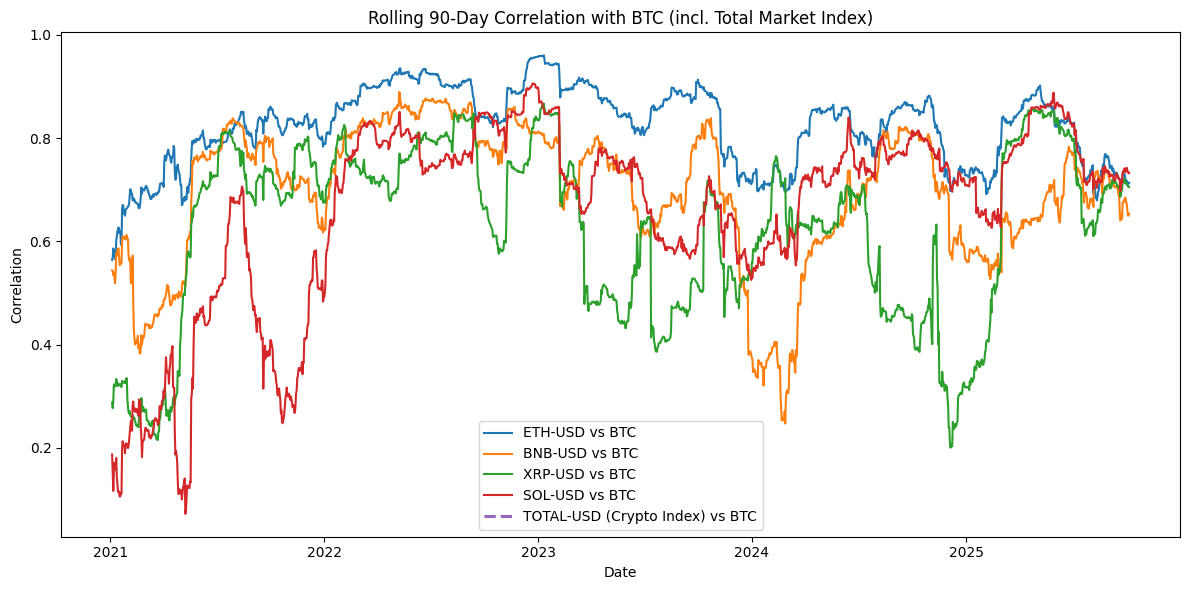


=== Cross-Correlation vs BTC (lags -7..+7) ===
ETH-USD   best_lag=+0  corr=0.806  (Simultaneous)
BNB-USD   best_lag=+0  corr=0.653  (Simultaneous)
XRP-USD   best_lag=+0  corr=0.558  (Simultaneous)
SOL-USD   best_lag=+0  corr=0.583  (Simultaneous)


In [ ]:
# ===== Crypto co-movement with Bitcoin (5Y) =====
# Requirements: yfinance, pandas, numpy, matplotlib
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Download 5Y daily close prices
tickers = ["BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "SOL-USD"]  # top non-stable tokens
data = yf.download(tickers, period="5y", interval="1d", auto_adjust=False)["Close"].dropna(how="all")
data = data.fillna(method="ffill").dropna(axis=0, how="any")  # align

# 2) Plot prices (log scale) for readability
plt.figure(figsize=(12, 6))
for t in tickers:
    plt.plot(data.index, data[t], label=t)
plt.yscale("log")
plt.title("Crypto Prices (log scale, last 5 years)")
plt.ylabel("Price (USD, log)")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Compute daily log returns
logp = np.log(data)
rets = logp.diff().dropna()

# 4) Plot returns
plt.figure(figsize=(12, 6))
for t in tickers:
    plt.plot(rets.index, rets[t], label=t, alpha=0.7)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Daily Log Returns (last 5 years)")
plt.ylabel("Log Return")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

# 5) Pearson correlation matrix of returns
corr = rets.corr()
print("\n=== Pearson Correlation of Daily Returns (5Y) ===")
print(corr.to_string(float_format=lambda x: f"{x:0.3f}"))

# 6) Regress each alt on BTC returns: r_alt = alpha + beta * r_btc + eps
btc = rets["BTC-USD"].values
print("\n=== OLS on BTC returns (beta, R^2) ===")
for t in ["ETH-USD", "BNB-USD", "XRP-USD", "SOL-USD"]:
    y = rets[t].values
    X = np.column_stack([np.ones_like(btc), btc])              # [1, r_btc]
    # OLS via normal equations
    coef = np.linalg.lstsq(X, y, rcond=None)[0]                # [alpha, beta]
    y_hat = X @ coef
    ss_res = np.sum((y - y_hat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - ss_res/ss_tot
    print(f"{t:8s}  beta={coef[1]:0.3f}  R^2={r2:0.3f}")

# 7) Rolling 90-day correlation vs BTC, including total crypto market index
tickers_extra = ["TOTAL-USD"]  # total crypto market cap index
extra_data = yf.download(tickers_extra, period="5y", interval="1d", auto_adjust=False)["Close"]
extra_data = extra_data.fillna(method="ffill").dropna()

# Align date indexes
common_idx = rets.index.intersection(extra_data.index)
rets_extra = np.log(extra_data.loc[common_idx]).diff().dropna()

window = 90
plt.figure(figsize=(12, 6))

# Alts vs BTC
for t in ["ETH-USD", "BNB-USD", "XRP-USD", "SOL-USD"]:
    roll = rets["BTC-USD"].rolling(window).corr(rets[t])
    plt.plot(roll.index, roll, label=f"{t} vs BTC")

# TOTAL-USD (market index) vs BTC
roll_total = rets["BTC-USD"].rolling(window).corr(rets_extra["TOTAL-USD"])
plt.plot(roll_total.index, roll_total, label="TOTAL-USD (Crypto Index) vs BTC",
         linewidth=2.2, linestyle="--")

plt.title(f"Rolling {window}-Day Correlation with BTC (incl. Total Market Index)")
plt.ylabel("Correlation")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

# 8) Lead/Lag cross-correlation (±7 days): does BTC lead?
max_lag = 7
print(f"\n=== Cross-Correlation vs BTC (lags -{max_lag}..+{max_lag}) ===")
for t in ["ETH-USD", "BNB-USD", "XRP-USD", "SOL-USD"]:
    x = btc - btc.mean()
    y = rets[t].values - rets[t].values.mean()
    # compute correlation at each lag; lag>0 means BTC leads by 'lag' days
    lags = range(-max_lag, max_lag + 1)
    cc = []
    for k in lags:
        if k > 0:
            a, b = x[:-k], y[k:]
        elif k < 0:
            a, b = x[-k:], y[:k]
        else:
            a, b = x, y
        if len(a) > 10:
            cc.append(np.corrcoef(a, b)[0, 1])
        else:
            cc.append(np.nan)
    # report the best lag
    best_idx = int(np.nanargmax(np.abs(cc)))
    best_lag = list(lags)[best_idx]
    best_val = cc[best_idx]
    direction = "BTC leads" if best_lag > 0 else ("Alt leads" if best_lag < 0 else "Simultaneous")
    print(f"{t:8s}  best_lag={best_lag:+d}  corr={best_val:0.3f}  ({direction})")


In [ ]:
# Pairs Z-Score Mean-Reversion with Beta Hedge (5Y, Daily)
# - Simple, auditable, beta-neutral relative value
# - Works for crypto (alts vs BTC) and equities (stock vs sector/peer)

import numpy as np
import pandas as pd
import yfinance as yf

# ---------- Config ----------
# Crypto pairs (alts vs BTC). Edit as you like.
crypto_pairs = [
    ("ETH-USD", "BTC-USD"),
    ("BNB-USD", "BTC-USD"),
    ("SOL-USD", "BTC-USD"),
    ("XRP-USD", "BTC-USD"),
]
# Equity pairs: stock vs sector/peer (NVDA vs semis ETF; ORCL vs MSFT as proxy)
equity_pairs = [
    ("NVDA", "SOXX"),
    ("ORCL", "MSFT"),
]

start, end = "2020-01-01", None  # 5Y+ backtest (None = today)
window = 60                      # rolling window for hedge & z-score
z_in, z_out = 2.0, 0.5           # entry/exit thresholds
cost_per_leg = 0.0005            # 5 bps per trade-leg (edit per venue)
notional = 1.0                   # trade 1 unit of spread (A - beta*B)

pairs = crypto_pairs + equity_pairs

# ---------- Data ----------
tickers = sorted(set([t for pair in pairs for t in pair]))
px = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
px = px.dropna(how="all").ffill().dropna()  # clean: ffill then drop leading NaNs

# ---------- Backtest ----------
results = []
equity_curve = {}

for A, B in pairs:
    if A not in px.columns or B not in px.columns:
        continue

    PA = px[A].astype(float)
    PB = px[B].astype(float)

    # Rolling beta: Cov(A,B)/Var(B) (uses prices; you can swap to returns—prices is fine here for spread)
    rPA = PA.pct_change()
    rPB = PB.pct_change()
    cov = rPA.rolling(window).cov(rPB)
    varB = rPB.rolling(window).var()
    beta = cov / varB
    beta = beta.replace([np.inf, -np.inf], np.nan).ffill()

    # Spread and its z-score
    spread = PA - beta * PB
    m = spread.rolling(window).mean()
    s = spread.rolling(window).std()
    z = (spread - m) / s

    # Signals (shifted to avoid lookahead)
    long_sig = (z < -z_in).astype(int)
    short_sig = (z > +z_in).astype(int)
    flat_sig = (z.abs() < z_out).astype(int)

    pos = pd.Series(0, index=spread.index, dtype=float)
    in_pos = 0
    for i in range(len(pos)):
        if np.isnan(z.iloc[i]):
            pos.iloc[i] = 0 if in_pos == 0 else pos.iloc[i-1]
            continue
        if in_pos == 0:
            if long_sig.iloc[i] == 1:
                in_pos = +1
            elif short_sig.iloc[i] == 1:
                in_pos = -1
        else:
            if flat_sig.iloc[i] == 1:
                in_pos = 0
        pos.iloc[i] = in_pos

    # Position in legs: +1 spread = +A, -beta*B. Use yesterday's signal to trade today.
    posA = (pos.shift(1).fillna(0)) * notional
    posB = -(pos.shift(1).fillna(0)) * beta * notional

    # Daily P&L from leg returns (prices → returns)
    retA = PA.pct_change().fillna(0)
    retB = PB.pct_change().fillna(0)
    pnl_gross = posA * retA + posB * retB

    # Trading cost (per change in position): 2 legs, apply bps on notional turnover
    turns = pos.diff().abs().fillna(0)
    cost = turns * (abs(notional) * cost_per_leg + abs(beta * notional) * cost_per_leg)
    pnl_net = pnl_gross - cost

    # Equity curve and metrics
    equity = (1 + pnl_net).cumprod()
    equity_curve[f"{A}/{B}"] = equity

    ann_factor = 252
    mu = pnl_net.mean() * ann_factor
    sigma = pnl_net.std(ddof=0) * np.sqrt(ann_factor)
    sharpe = 0.0 if sigma == 0 else mu / sigma

    cum = equity
    peak = cum.cummax()
    mdd = ((cum / peak) - 1).min()

    days = (equity.index[-1] - equity.index[0]).days
    cagr = (equity.iloc[-1]) ** (365.25 / days) - 1 if days > 0 else np.nan

    wins = (pnl_net > 0).sum()
    total = (pnl_net != 0).sum()
    winrate = wins / total if total > 0 else np.nan

    results.append({
        "Pair": f"{A}/{B}",
        "Sharpe": round(sharpe, 2),
        "CAGR": round(cagr, 3),
        "MaxDD": round(mdd, 3),
        "WinRate": round(winrate, 3),
        "Trades": int(turns.sum())
    })

# ---------- Report ----------
perf = pd.DataFrame(results).sort_values("Sharpe", ascending=False)
print(perf.to_string(index=False))

# (Optional) Save curves to CSV
pd.DataFrame(equity_curve).to_csv("pairs_equity_curves.csv")


           Pair  Sharpe   CAGR  MaxDD  WinRate  Trades
XRP-USD/BTC-USD    0.73  0.400 -0.738    0.451      54
BNB-USD/BTC-USD    0.61  0.286 -0.641    0.441      57
ETH-USD/BTC-USD    0.24  0.042 -0.392    0.418      71
SOL-USD/BTC-USD   -0.23 -0.315 -0.943    0.428      63
      ORCL/MSFT   -0.32 -0.129 -0.625    0.427      60
      NVDA/SOXX   -0.42 -0.124 -0.618    0.433      59


In [ ]:
# ---- One-month live-style evaluation (T+1, daily) ----
initial_capital_gbp = 100.0

# Choose evaluation window: last 21 trading days (~1 month)
# You can also choose exact dates: last_1m = (pnl_net.index >= "2025-09-01") & (pnl_net.index <= "2025-09-30")
window_days = 21

per_pair_monthly = []         # store per-pair one-month results
pair_daily_returns = {}       # keep daily series to make a simple basket later

for A, B in pairs:
    key = f"{A}/{B}"
    if key not in equity_curve:
        continue

    # Reconstruct this pair's daily net returns from its equity curve
    eq = equity_curve[key]
    r = eq.pct_change().fillna(0)  # daily net returns (includes costs & position shifts)
    last_1m = r.index[-window_days:] if len(r) >= window_days else r.index

    r1m = r.loc[last_1m]
    gross_month_return = (1 + r1m).prod() - 1
    final_capital = initial_capital_gbp * (1 + gross_month_return)
    profit_gbp = final_capital - initial_capital_gbp

    per_pair_monthly.append({
        "Pair": key,
        "1M_Return": round(gross_month_return, 4),
        "Start(£)": round(initial_capital_gbp, 2),
        "End(£)": round(final_capital, 2),
        "Profit(£)": round(profit_gbp, 2)
    })
    pair_daily_returns[key] = r1m

# Print per-pair 1M results
one_m = pd.DataFrame(per_pair_monthly).sort_values("1M_Return", ascending=False)
print("\n=== 1-MONTH REALIZED PERFORMANCE (T+1) ===")
print(one_m.to_string(index=False))

# Optional: equal-weight basket of top N pairs (e.g., N=2 best crypto pairs)
N = 2
top_pairs = one_m.head(N)["Pair"].tolist()
if top_pairs:
    # Align daily indices and take simple average of returns each day
    aligned = pd.concat([pair_daily_returns[p] for p in top_pairs], axis=1).dropna()
    basket_r = aligned.mean(axis=1)
    basket_1m_ret = (1 + basket_r).prod() - 1
    basket_end = initial_capital_gbp * (1 + basket_1m_ret)
    print(f"\n=== Equal-Weight Basket (Top {N}) ===")
    print(f"Pairs: {top_pairs}")
    print(f"1M_Return: {basket_1m_ret:.4f}  Start(£): {initial_capital_gbp:.2f}  End(£): {basket_end:.2f}  Profit(£): {basket_end - initial_capital_gbp:.2f}")



=== 1-MONTH REALIZED PERFORMANCE (T+1) ===
           Pair  1M_Return  Start(£)  End(£)  Profit(£)
BNB-USD/BTC-USD     0.1882     100.0  118.82      18.82
      ORCL/MSFT     0.0293     100.0  102.93       2.93
      NVDA/SOXX    -0.0098     100.0   99.02      -0.98
XRP-USD/BTC-USD    -0.0335     100.0   96.65      -3.35
ETH-USD/BTC-USD    -0.1181     100.0   88.19     -11.81
SOL-USD/BTC-USD    -0.1425     100.0   85.75     -14.25

=== Equal-Weight Basket (Top 2) ===
Pairs: ['BNB-USD/BTC-USD', 'ORCL/MSFT']
1M_Return: 0.1093  Start(£): 100.00  End(£): 110.93  Profit(£): 10.93
